In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyyaml==5.3.1
!pip install -U torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/cu101/torch_stable.html 

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version


import torch
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
!git clone https://github.com/facebookresearch/detectron2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 269 kB 14.6 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=f140d353c815cdc81a3f0ccb536267d2caac74418bf20e4aa7d13cb295feb6b7
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 735.4 MB 15 kB/s 
     |████████████████████████████████| 12.8 MB 566 kB/s 
     |████████████████████████████████| 7.6 MB 13.8 MB/s 
  Attempting uninstall: torch
    Found existing instal

Cloning into 'detectron2'...
remote: Enumerating objects: 14560, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 14560 (delta 11), reused 16 (delta 6), pack-reused 14527
Receiving objects: 100% (14560/14560), 5.96 MiB | 7.84 MiB/s, done.
Resolving deltas: 100% (10521/10521), done.


In [1]:

import cv2
from tqdm import tqdm
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from pycocotools import mask as mutils

from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.engine import DefaultTrainer
from LossEvalHook import LossEvalHook 
import os
import json
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

import torch
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.patches as patches
 
from detectron2 import model_zoo
import random
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
import iopath
from detectron2.evaluation import COCOEvaluator, inference_on_dataset



In [ ]:
!nvidia-smi

Sat Oct  8 09:45:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# #@title Calculate bbox and save new coco json

# root_dir = '/content/drive/MyDrive/InstanceSegmentation/Dataset/dataverse_files/'
# annotations_dir = 'annotations_EVICAN2/'

# json_files = os.listdir(root_dir+annotations_dir)
# for path in json_files:
#   path = root_dir+annotations_dir+path
#   f = open(path)
#   anns = json.load(f)
#   coco=COCO(path)
#   # convert masks to annotations
#   for i in range(len(anns['annotations'])):
#     bbox = list(map(int,mutils.toBbox(coco.annToRLE(anns['annotations'][i])).tolist()))
#     anns['annotations'][i]['bbox'] = bbox
#     anns['annotations'][i]['area'] = bbox[2]*bbox[3]

#   with open(path.split('.')[0]+'_bbox.json', 'w') as f:
#     json.dump(anns, f)



In [ ]:
#@title Calculate 'bbox' and 'area', storing and display

ann = anns['annotations'][10]
print(ann)
ann['bbox'] = mutils.toBbox(coco.annToRLE(ann)).tolist()
images_path = '/content/drive/MyDrive/InstanceSegmentation/Dataset/dataverse_files/Images/EVICAN_train2019/11_769p.jpg'
image = Image.open(images_path)
 
fig, ax = plt.subplots()
 
# Draw boxes and add label to each box
# for ann in anns:
box = ann['bbox']
bb = patches.Rectangle((box[0],box[1]), box[2],box[3], linewidth=2, edgecolor="blue", facecolor="none")
ax.add_patch(bb)
 
ax.imshow(image)
plt.show()

In [2]:
#@title Loading out Evican2 COCO Dataset 


root_dir = '/content/drive/MyDrive/InstanceSegmentation/Dataset/dataverse_files/'
annotations_dir = 'annotations_EVICAN2/'

register_coco_instances("my_dataset_train", {}, root_dir+annotations_dir+"instances_train2019_EVICAN2_bbox.json", root_dir+'Images/EVICAN_train2019')
register_coco_instances("my_dataset_val", {}, root_dir+annotations_dir+"instances_val2019_EVICAN2_bbox.json", root_dir+'Images/EVICAN_val2019')
register_coco_instances("my_dataset_eval", {}, root_dir+annotations_dir+"instances_eval2019_medium_EVICAN2_bbox.json", root_dir+'Images/EVICAN_eval2019')

[10/11 12:33:12 d2.data.datasets.coco]: Loading /content/drive/MyDrive/InstanceSegmentation/Dataset/dataverse_files/annotations_EVICAN2/instances_train2019_EVICAN2_bbox.json takes 2.46 seconds.
[10/11 12:33:12 d2.data.datasets.coco]: Loaded 4464 images in COCO format from /content/drive/MyDrive/InstanceSegmentation/Dataset/dataverse_files/annotations_EVICAN2/instances_train2019_EVICAN2_bbox.json
/content/drive/MyDrive/InstanceSegmentation/Dataset/dataverse_files/Images/EVICAN_train2019/18_Background.jpg


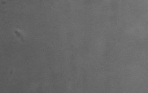

/content/drive/MyDrive/InstanceSegmentation/Dataset/dataverse_files/Images/EVICAN_train2019/1993_HT29.jpg


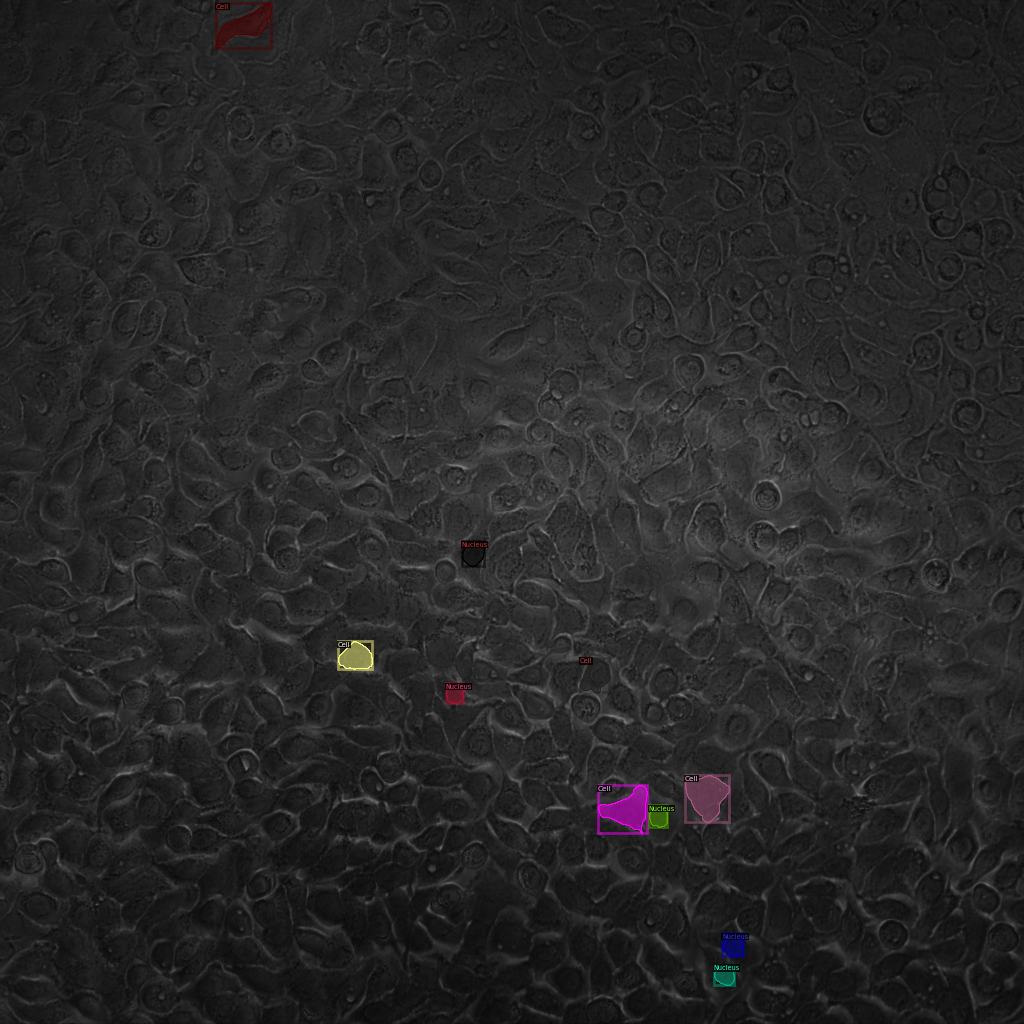

/content/drive/MyDrive/InstanceSegmentation/Dataset/dataverse_files/Images/EVICAN_train2019/2006_LNCaP.jpg


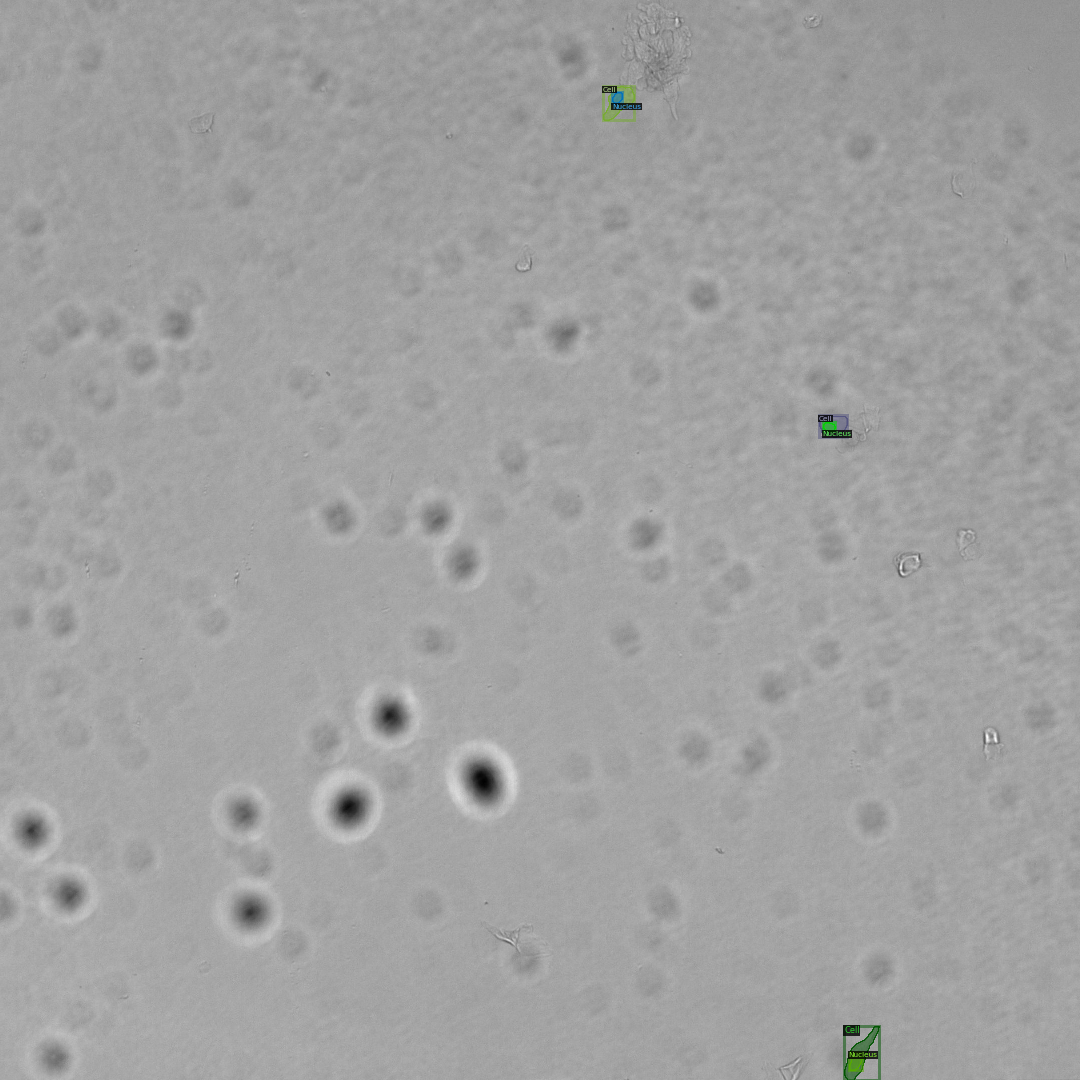

In [28]:


my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")


for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

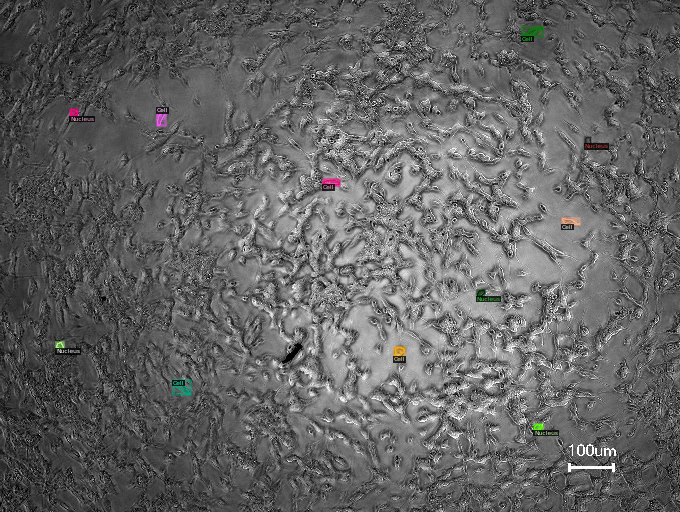

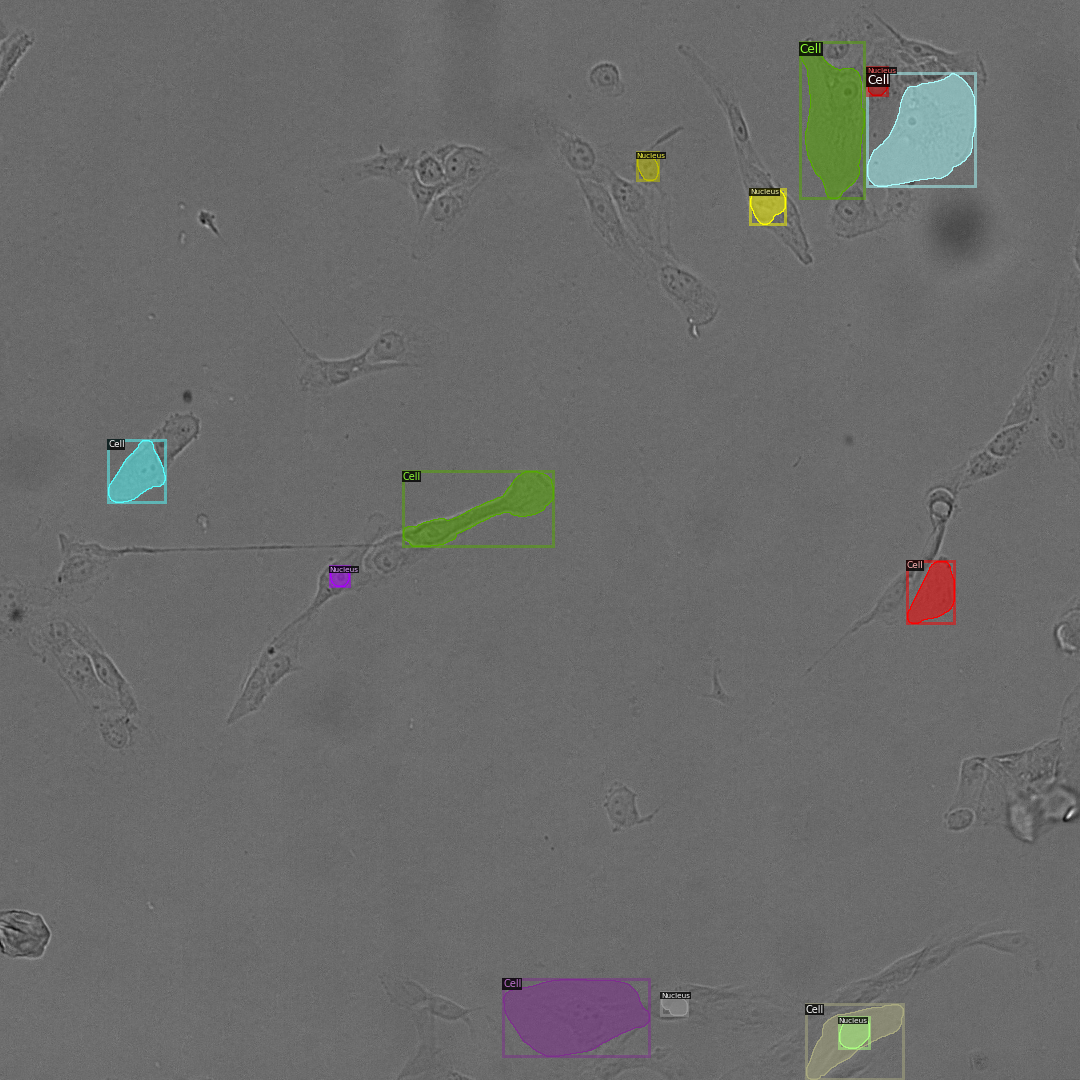

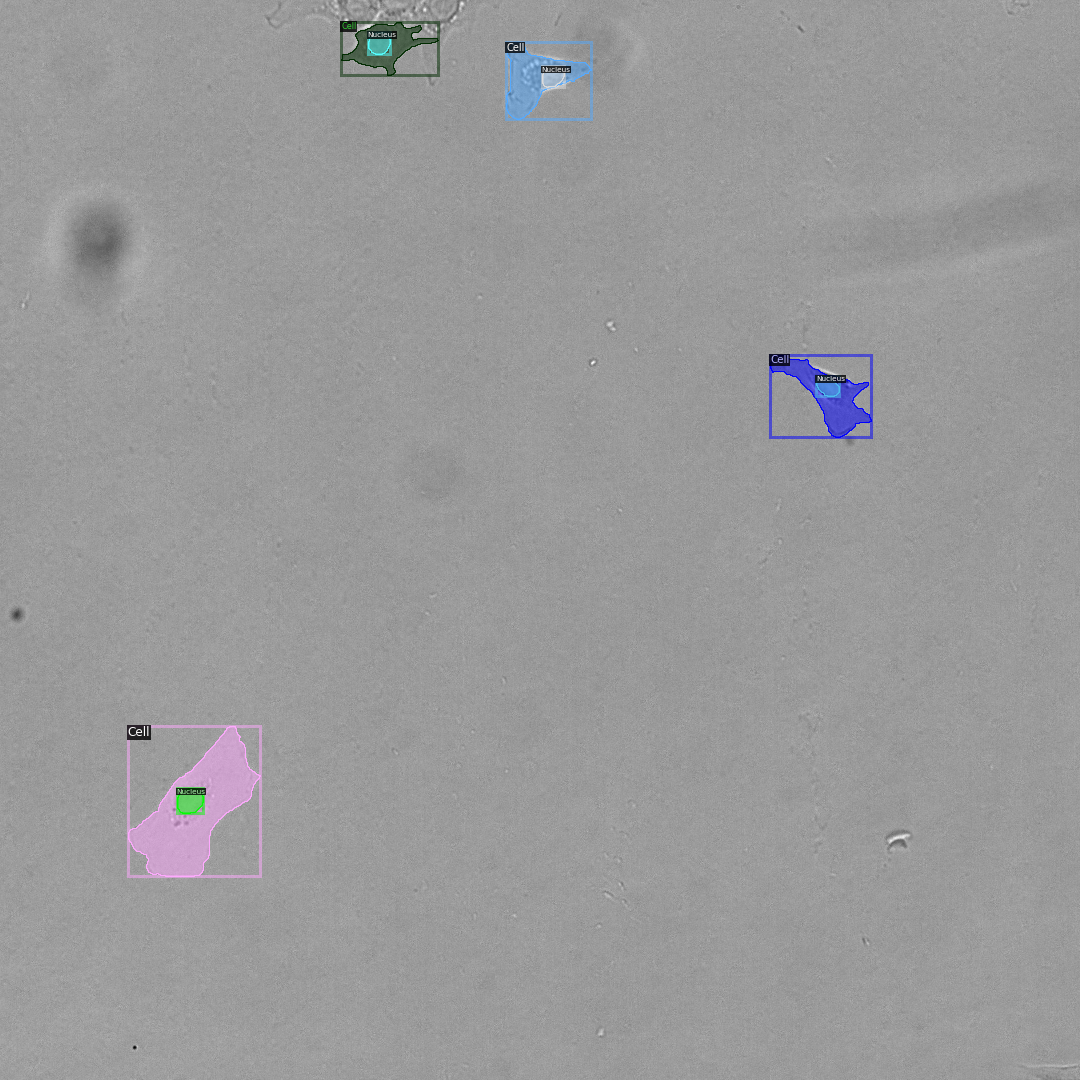

In [ ]:


my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")


for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [3]:
#@title Creating our own custom Detectron2 Trainer to log Validation Loss


class CustomTrainer(DefaultTrainer):
    """
    Custom Trainer deriving from the "DefaultTrainer"
    Overloads build_hooks to add a hook to calculate val loss on the val set during training.
    """

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1, LossEvalHook(
            100, # Frequency of calculation - every 100 iterations here
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg, True)
            )
        ))

        return hooks

In [13]:
#@title Traaining model on EVICAN2 COCO Dataset


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")


cfg.OUTPUT_DIR = "/content/drive/MyDrive/InstanceSegmentation/output/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05  # set the testing threshold for this model
cfg.TEST.EVAL_PERIOD = 200

# Solver options
cfg.SOLVER.CHECKPOINT_PERIOD = 500
cfg.SOLVER.BASE_LR = 0.00025           # Base learning rate
cfg.SOLVER.GAMMA = 0.5              # Learning rate decay
cfg.SOLVER.STEPS = (250, 500, 750)  # Iterations at which to decay learning rate
cfg.SOLVER.MAX_ITER = 3000          # Maximum number of iterations
cfg.SOLVER.WARMUP_ITERS = 100       # Warmup iterations to linearly ramp learning rate from zero
cfg.SOLVER.IMS_PER_BATCH = 2

trainer = CustomTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/11 05:25:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:14, 18.0MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[10/11 05:26:23 d2.engine.train_loop]: Starting training from iteration 0
[10/11 05:26:36 d2.utils.events]:  eta: 0:28:42  iter: 19  total_loss: 4.037  loss_cls: 1.003  loss_box_reg: 0.08249  loss_mask: 0.6912  loss_rpn_cls: 1.847  loss_rpn_loc: 0.3645  time: 0.5852  data_time: 0.1333  lr: 4.7703e-05  max_mem: 3669M
[10/11 05:26:48 d2.utils.events]:  eta: 0:27:54  iter: 39  total_loss: 2.189  loss_cls: 0.57  loss_box_reg: 0.0573  loss_mask: 0.6716  loss_rpn_cls: 0.5072  loss_rpn_loc: 0.4584  time: 0.5714  data_time: 0.0355  lr: 9.7653e-05  max_mem: 3903M
[10/11 05:27:00 d2.utils.events]:  eta: 0:28:21  iter: 59  total_loss: 1.656  loss_cls: 0.2354  loss_box_reg: 0.07987  loss_mask: 0.6238  loss_rpn_cls: 0.3536  loss_rpn_loc: 0.3258  time: 0.5799  data_time: 0.0350  lr: 0.0001476  max_mem: 3903M
[10/11 05:27:12 d2.utils.events]:  eta: 0:28:09  iter: 79  total_loss: 1.672  loss_cls: 0.2246  loss_box_reg: 0.09972  loss_mask: 0.5677  loss_rpn_cls: 0.3339  loss_rpn_loc: 0.3711  time: 0.5868

In [23]:
#@title Loading model for Evaluation on Eval/Test Dataset 

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/InstanceSegmentation/detectron2/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TEST = ("my_dataset_eval",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/InstanceSegmentation/output/model_0002999.pth'
cfg.INPUT.MAX_SIZE_TEST = 20000
cfg.SOLVER.IMS_PER_BATCH = 2   # increase this for more speed, but it will need more vram
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096   # or 128 for example
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05  # set the testing threshold for this model

predictor = DefaultPredictor(cfg)

[10/11 12:36:45 d2.data.datasets.coco]: Loading /content/drive/MyDrive/InstanceSegmentation/Dataset/dataverse_files/annotations_EVICAN2/instances_train2019_EVICAN2_bbox.json takes 2.46 seconds.
[10/11 12:36:45 d2.data.datasets.coco]: Loaded 4464 images in COCO format from /content/drive/MyDrive/InstanceSegmentation/Dataset/dataverse_files/annotations_EVICAN2/instances_train2019_EVICAN2_bbox.json


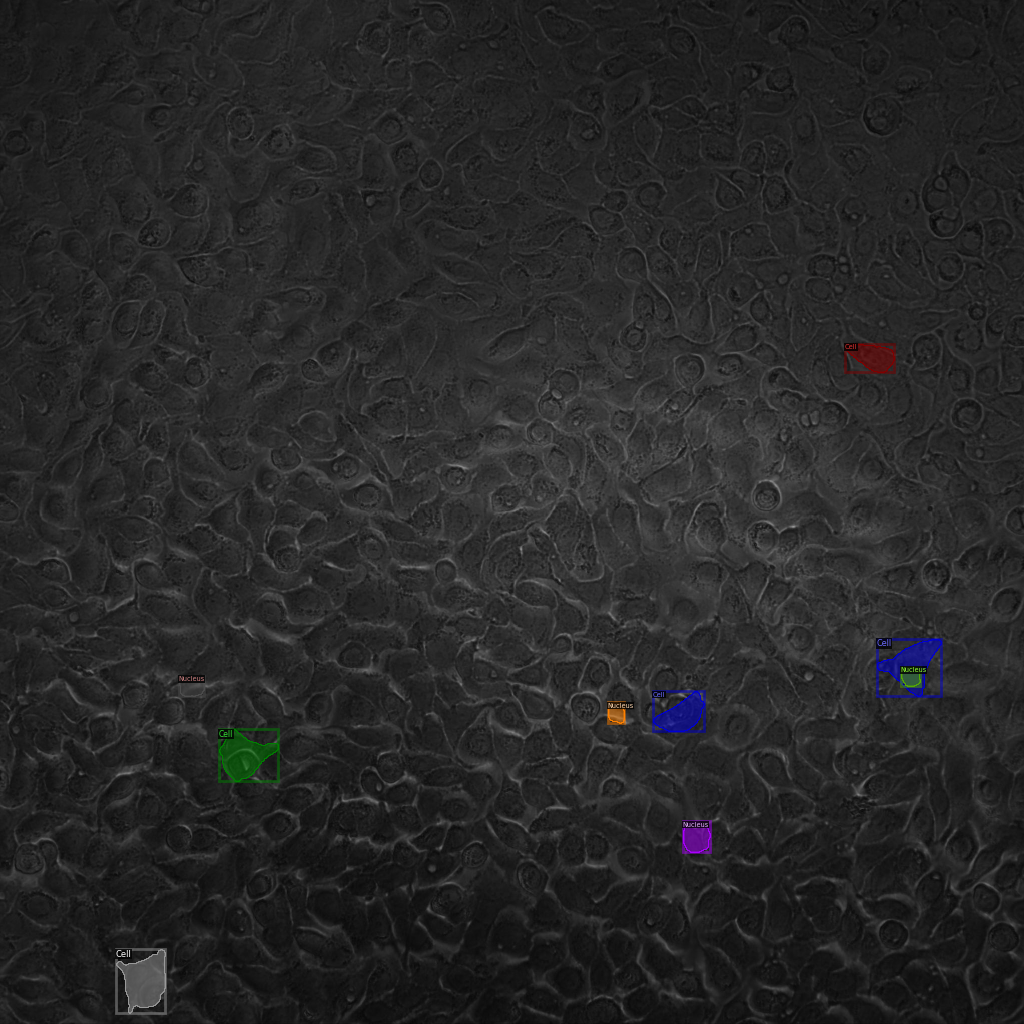

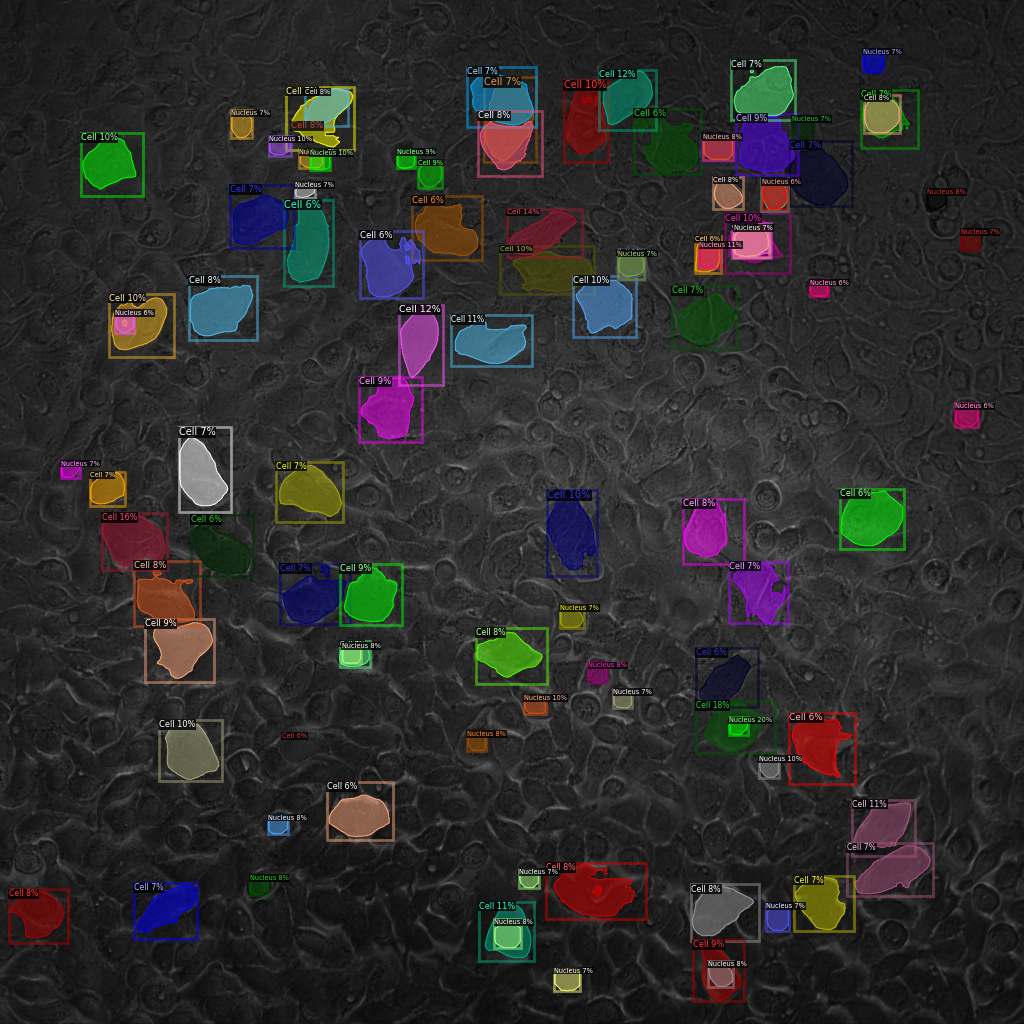

tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0], device='cuda:0')


In [32]:
#@title Visualizing the test results on test/eval images

my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

img = cv2.imread("/content/drive/MyDrive/InstanceSegmentation/Dataset/dataverse_files/Images/EVICAN_train2019/1993_HT29.jpg")
outputs = predictor(img)

visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
vis = visualizer.draw_dataset_dict(d)
cv2_imshow(vis.get_image()[:, :, ::-1])

visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(vis.get_image()[:, :, ::-1])
cv2.imwrite("img.jpg", vis.get_image()[:, :, ::-1])
print(outputs["instances"].pred_classes)
# print(outputs["instances"].pred_boxes)




[10/11 12:15:52 d2.data.datasets.coco]: Loaded 33 images in COCO format from /content/drive/MyDrive/InstanceSegmentation/Dataset/dataverse_files/annotations_EVICAN2/instances_eval2019_medium_EVICAN2_bbox.json


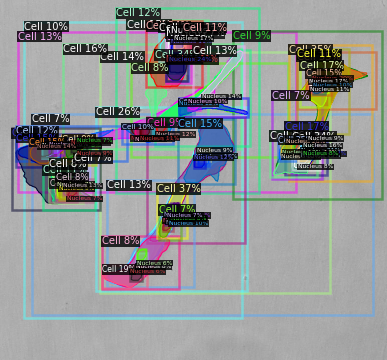

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1], device='cuda:0')


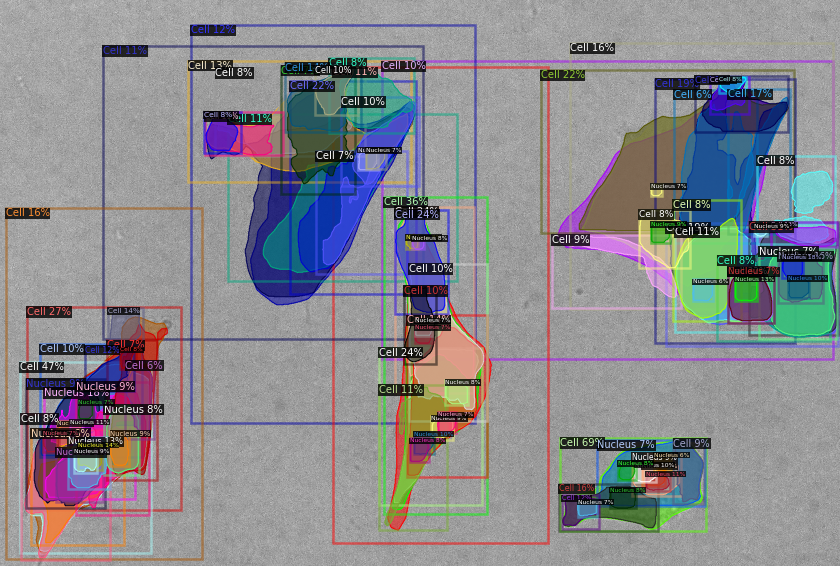

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 1], device='cuda:0')


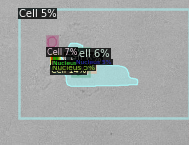

tensor([0, 1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')


In [27]:
#@title Visualizing the test results on test/eval images

my_dataset_train_metadata = MetadataCatalog.get("my_dataset_eval")
dataset_dicts = DatasetCatalog.get("my_dataset_eval")

cnt = 0 
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    # vis = visualizer.draw_dataset_dict(d)
    vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(vis.get_image()[:, :, ::-1])
    cv2.imwrite(str(cnt)+".jpg", vis.get_image()[:, :, ::-1])
    cnt +=1
    print(outputs["instances"].pred_classes)
    # print(outputs["instances"].pred_boxes)

In [33]:
#@title Evaluating model on Eval/Test Dataset 

evaluator = COCOEvaluator("my_dataset_eval", cfg, False, output_dir="output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_eval")
inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [10/11 12:59:28 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/11 12:59:28 d2.data.datasets.coco]: Loaded 33 images in COCO format from /content/drive/MyDrive/InstanceSegmentation/Dataset/dataverse_files/annotations_EVICAN2/instances_eval2019_medium_EVICAN2_bbox.json
[10/11 12:59:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=20000, sample_style='choice')]
[10/11 12:59:28 d2.data.common]: Serializing 33 elements to byte tensors and concatenating them all ...
[10/11 12:59:28 d2.data.common]: Serialized dataset takes 0.41 MiB
[10/11 12:59:28 d2.evaluation.evaluator]: Start inference on 33 batches
[10/11 12:59:31 d2.evaluation.evaluator]: Inference done 11/33. Dataloading: 0.0011 s/iter. Inference: 0.1334 s/iter. Eval: 0.0252 s/iter. Total: 0.1596 s/iter. ETA=0:00:03
[10/11 12:59:36 d2.evalua

OrderedDict([('bbox',
              {'AP': 10.21810154987114,
               'AP50': 22.782240186806774,
               'AP75': 7.158603783485269,
               'APs': 6.87854550620736,
               'APm': 10.137317188823305,
               'APl': 12.708086367450383,
               'AP-Cell': 18.558688076808576,
               'AP-Nucleus': 1.877515022933698}),
             ('segm',
              {'AP': 8.855863021841495,
               'AP50': 20.573737414676117,
               'AP75': 6.058321286198902,
               'APs': 4.369951540798967,
               'APm': 8.380569069247064,
               'APl': 12.700326865084255,
               'AP-Cell': 15.584578662101922,
               'AP-Nucleus': 2.1271473815810626})])

In [18]:
!python --version


Python 3.7.14


In [ ]:
# !pip freeze